## Encoder を 15 レイヤー用意し，時系列的に入力するモデルの検証


### Import


In [1]:
import python.util as util
from pathlib import Path
import importlib
from typing import Dict
# from transformers import RobertaForSequenceClassification
import torch
from datasets import Dataset
import pandas as pd
import numpy as np
import yaml

### DEFINE PATH


In [2]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "model"
print(f"BASE_PATH: {BASE_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODEL_PATH: {MODEL_PATH}")

BASE_PATH: /home/masa1357/Dockerdata/gitfile/15-Encoders
DATA_PATH: /home/masa1357/Dockerdata/gitfile/15-Encoders/data
MODEL_PATH: /home/masa1357/Dockerdata/gitfile/15-Encoders/model


### Set Seed & Set Logger


In [3]:
importlib.reload(util)
# ? logger読み込み
name = "15-Ensemble"
logger = util.set_logger()
# ? seed値固定
seed = 42
util.set_seed(seed)

2024-10-04 16:55:48,194 : python.util : INFO : 34 : Test_message


In [4]:
# ? データ読み込み
import python.data_manager as dm

importlib.reload(dm)
# argsでloggerの名前を送る

args: Dict[str, object] = {
    "logger": logger,
    "DATA_PATH": DATA_PATH,
    "key": "userid",
    "text": "answer_content",
    "label": "grade",
    "mode": "all",
    "split_rate": [0.8, 0.2, 0],
    "seed": seed,
}

with util.timer("load data"):
    dp = dm.DataProcessing(args)
    df = dp()

2024-10-04 16:55:48,206 : python.util.python.data_manager : INFO : 16 : setup Child logger : python.data_manager
2024-10-04 16:55:48,207 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/15-Encoders/data/Reflection *.csv data...
2024-10-04 16:55:48,208 : python.util.python.data_manager : INFO : 67 : Found files: [PosixPath('/home/masa1357/Dockerdata/gitfile/15-Encoders/data/Reflection/Course_C-2021-2_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/15-Encoders/data/Reflection/Course_C-2022-1_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/15-Encoders/data/Reflection/Course_C-2021-1_Reflection.csv')]
2024-10-04 16:55:48,294 : python.util.python.data_manager : INFO : 74 : Total rows: 28275
2024-10-04 16:55:48,295 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/15-Encoders/data/Grade *.csv data...
2024-10-04 16:55:48,296 : python.util.python.data_manager : INFO : 67 : Found files: [Pos

[load data] start
[load data] done in 0.73 s


In [5]:
df.head(3)

,userid,grade,text,course_number,question_number,label
0,C-2021-1_U1,F,情報伝達には声モルス信号など様々な形があり人類の進化と共により高度に精度が高められてきた,01,1,4
1,C-2021-1_U10,B,高校時代で習った情報だけでは現代の進化についていけない\r\n情報はどんな形であっても〇と●...,01,1,1
2,C-2021-1_U100,C,情報の発展の仕方\r\n授業の参加の仕方,01,1,2


### 各生徒の回答を時系列でグループ化


In [6]:
# 質問番号でフィルタ
filter = "1"
Qfilter_df = dm.encode(df, logger=logger, filter=filter)
Qfilter_df.head(3)

/home/masa1357/Dockerdata/gitfile/15-Encoders/src/python/data_manager.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "new_column"] = df.apply(create_column_name, axis=1)


new_column,userid,label,01-1,02-1,03-1,04-1,05-1,06-1,07-1,08-1,09-1,10-1,11-1,12-1,13-1,14-1,15-1
0,C-2021-1_U1,4,情報伝達には声モルス信号など様々な形があり人類の進化と共により高度に精度が高められてきた,情報源符号化とは情報を黒と白の○で表すことで複合とは符号化によって得られたものを元に戻す作業...,生起確率pの事象の生起を知ったことによる曖昧さの減少量は情報量と一致し生起確率pが高いほど情...,通信の際に符号の誤りを検出・訂正する仕組みについて学んだ符号の誤りは符号語同士がs+1以上離...,コンピュタサイエンスは計算機科学であるともされ全ての科学技術分野の基盤となりうるものであるコ...,計算ステップ数とはアルゴリズムが終了するまでに行われる演算の数である最大公約数の問題では剰余...,マジソトとは入力数列を分割していき分割したものを整列して統合(マジ)するアルゴリズムであるヒ...,[NA],[NA],[NA],[NA],[NA],[NA],[NA],[NA]
1,C-2021-1_U10,1,高校時代で習った情報だけでは現代の進化についていけない\r\n情報はどんな形であっても〇と●...,どのように情報を短く表現するか\r\n符号をを一意に素早く戻すためにはどのような符号にすればよいか,情報の量を表すためにはどのようにすればよいか\r\n2つの現象が起こった場合相互の情報量はど...,誤りの自動検出と自動訂正が可能なハミング距離\r\n符号化効率とブロック誤り率,基礎科学としてのコンピュタサイエンス\r\nコンピュタサイエンスにおける計算と問題とは何か\...,色々なソトの種類とその計算時間量や比較回数\r\n,マジソトと2分探索法\r\n比較ベスのソトアルゴリズムのまとめ,デタとは何か\r\nデタの予測発見分類・グルピング\r\n,人工知能(AI)特化型AIとは何か\r\n身の回りの人工知能\r\n人工知能の機械学習\r\...,非構造化デタの処理\r\nパタン認識とは何か\r\nパタン認識と機械学習,デタ収集とバイアス\r\n個人情報とデタ\r\nオプンデタについて,ベクトルによるデタ表現ベクトルとは何か\r\nベクトルとデタ分析の関係\r\n距離や類似度と...,デタの可視化とは\r\n色々な可視化方法\r\n多次元デタの可視化,相関デタの広がりと分散\r\n統計的検定とは何か\r\n画像処理と解析(フィルタ処理),期末テスト\r\n授業アンケト
2,C-2021-1_U100,2,情報の発展の仕方\r\n授業の参加の仕方,情報源符号化によって情報が伝えられるときより軽く瞬時に伝わるような仕組み,エントロピ情報量について,通信路符号化ビット反転によってノイズが生じる仕組み自動訂正自動検出について,計算とアルゴリズムについて効率のよい計算,いろいろなソトについて,マジソト2分探索法について,デタについて,AIについての基礎情報,非構造デタとはパタン認識とは,デタの収集にはどのような方法があるのか調査方法バイアスとは個人情報について,ベクトルについていろいろな距離についてデタにおける類似とは,デタの可視化について,デタの間の関係性相関統計的検定について画像解析フィルタ処理について,期末テスト


### Convert to Dataset


In [7]:
from transformers import RobertaTokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nlp-waseda/roberta-base-japanese")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [8]:
# example dfを作り，モデル動作の確認用に用いる
# -> 行：5, 列：2
example_df = Qfilter_df[['userid','01-1', 'label']].sample(32, random_state=seed).reset_index(drop=True)
#01-1をtextにrename
example_df = example_df.rename(columns={'01-1': 'text'})
example_df.head(3)

new_column,userid,text,label
0,C-2022-1_U56,情報科学は高校までの情報の授業とは異なり数理的に情報を扱う学問である\r\n情報分野は今の世...,1
1,C-2021-1_U32,昔から様々な方法で情報は伝達されてきた\r\nそれは近代になって複雑に暗号化された,0
2,C-2021-1_U16,情報科学の授業で使う電子教科書の使い方と情報とは一体何なのかということをイントロダクションと...,2


In [9]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import WeightedRandomSampler

# ラベルの頻度を計算
labels = Qfilter_df["label"].tolist() 
label_counts = np.bincount(labels)
# 各ラベルの重みを計算（頻度の逆数）
weights = 1.0 / label_counts
# 各サンプルの重みをリストで作成
sample_weights = weights[labels]
# WeightedRandomSamplerの作成

sampler = WeightedRandomSampler(
    weights=sample_weights, num_samples=len(sample_weights), replacement=True
)

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, multi=False):
        self.tokenizer = tokenizer
        self.data = dataframe
        if multi:
            c = '01-1'
        else:
            c = 'text'
        self.text = dataframe[c]
        self.labels = dataframe['label']
        self.max_len = max_len
        self.multi = multi

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):

        # logger.info(f"index: {index}, text: {text}, labels: {labels}")
        # print(f"index: {index}, text: {text}, labels: {labels}")

        row = self.data.iloc[index]
        if self.multi:
            #INFO: 1つのuseridに対して複数の質問がある場合
            #INFO: 全ての質問をエンコード
            #INFO: 回答文の列名は%2d-%dの形式となっている
            ids = []
            attn = []
            texts = []
            for i in range(1, 16):
                col_name = f'{str(i).zfill(2)}-1' 
                text = row[col_name]
                # logger.info(f"index: {index}, col_name: {col_name}, text: {text}")
                # i回目講義の回答文をエンコード
                encoding = self.tokenizer(
                    text,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    padding="max_length",
                    return_attention_mask=True,
                    return_tensors="pt",
                    truncation=True,
                )
                #INFO: 各回答エンコードをリストとして保管
                ids.append(encoding['input_ids'].flatten())
                attn.append(encoding['attention_mask'].flatten())
                texts.append(text)
            

            ids = torch.stack(ids)
            attn = torch.stack(attn)
            labels = row['label']
            return {
                'input_ids': ids,
                'attention_mask': attn,
                'labels': torch.tensor(labels, dtype=torch.long),
                'text': texts,
                'id': row['userid'],
            }

        else :
            text = row['text']
            labels = row['label']
            encoding =  self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding="max_length",
                return_attention_mask=True,
                return_tensors="pt",
                truncation=True,
            )

            input_ids = encoding['input_ids'].flatten()
            attention_mask = encoding['attention_mask'].flatten()

            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'labels': torch.tensor(labels, dtype=torch.long),
                'text': text,
                'id': row['userid'],
            }

def make_dataloader(dataframe, tokenizer, batch_size=32, max_len=512, multi=False):
    logger.info(f"batch_size: {batch_size}, max_len: {max_len}")
    if multi:
        dataset = CustomDataset(dataframe, tokenizer, max_len, multi=True)
    else:
        dataset = CustomDataset(dataframe, tokenizer, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True)
    return dataset, dataloader



In [10]:
# Example usage
ex_dataset, ex_dataloader = make_dataloader(example_df, tokenizer)

2024-10-04 16:55:50,058 : python.util : INFO : 104 : batch_size: 32, max_len: 512


In [11]:
ex_dataset[0]

{'input_ids': tensor([    2,   570,  4757,  3235,  3228,  1856,  8757,   444,   561,   353,
          5426,  5547,   353, 29562,  3474,   961,  3228, 16247, 10219,  2599,
          5318,  1785,   333,  5426,  5547, 20762, 31363,   906,  3235, 11127,
          1072,   570,  2497,   813,  3228, 16920,   353,  2291,   353,  1610,
          2497, 15539, 11127,   450,  2276, 20122,  7981,   856,   636,  3228,
           797,   961,  4015,   353,  1988,  3872,  4344,   353,  1506,  3333,
           353,  3937,   721, 12898,   561,  6922,   363,  1104,  1007,   636,
          3804,   333,  3228,  8945,  1498,   368, 27360,  3630,  1459,  3167,
           341,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [12]:
print(f"Number of samples: {len(ex_dataset)}")

Number of samples: 32


In [13]:
# train_dataloaderの確認
for data in ex_dataloader:
    print(data)

{'input_ids': tensor([[    2,   570,  4757,  ...,     0,     0,     0],
        [    2,  5419,  3652,  ...,     0,     0,     0],
        [    2,   570,  4757,  ...,     0,     0,     0],
        ...,
        [    2,  4063,   961,  ...,     0,     0,     0],
        [    2, 29752,  1070,  ...,     0,     0,     0],
        [    2,  4334,   353,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 2, 2, 1, 3, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 4, 2, 3,
        2, 1, 2, 4, 2, 2, 3, 1]), 'text': ['情報科学は高校までの情報の授業とは異なり数理的に情報を扱う学問である\r\n情報分野は今の世の中分離問わず必須\r\nデタは１と０の二種類の文字の組み合わせで表されデタ量には様々な単位がある', '昔から様々な方法で情報は伝達されてきた\r\nそれは近代になって複雑に暗号化された', '情報科学の授業で使う電子教科書の使い方と情報とは一体何なのかということをイントロダクションとして学んだ原始時代では口頭や狼煙を用いた情報伝達手段しかなかったが０と１を用いて近年ではさまざまな手段で情報伝達が可能になっ

In [14]:
train_dataset, train_dataloader = make_dataloader(Qfilter_df, tokenizer, batch_size=4, max_len=128, multi=True)

2024-10-04 16:55:50,110 : python.util : INFO : 104 : batch_size: 4, max_len: 128


In [15]:
# train_datasetの確認
display(train_dataset[0])
# train_datasetの形状確認
display("train_datasetの形状", train_dataset[0].keys())

# train_datasetの行数確認
display("train_datasetの行数", len(train_dataset))


{'input_ids': tensor([[   2,  570, 3433,  ...,    0,    0,    0],
         [   2,  570, 8434,  ...,    0,    0,    0],
         [   2,  634, 8498,  ...,    0,    0,    0],
         ...,
         [   2,  684, 8793,  ...,    0,    0,    0],
         [   2,  684, 8793,  ...,    0,    0,    0],
         [   2,  684, 8793,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor(4),
 'text': ['情報伝達には声モルス信号など様々な形があり人類の進化と共により高度に精度が高められてきた',
  '情報源符号化とは情報を黒と白の○で表すことで複合とは符号化によって得られたものを元に戻す作業のことであるそれらの過程の中で平均符号語長を短くすることが目指されるそこで一意符号可能性と瞬時復号可能性を持つ語頭符号を用いる\r\nエントロピとは平均符号語長の下限のことである',
  '生起確率pの事象の生起を知ったことによる曖昧さの減少量は情報量と一致し生起確率pが高いほど情報量は現状しまた逆もしかりであるまたエントロピは情報量の期待値と一致する相互情報量とはある事象2つが相互に関連して生起した場合に得られる情報量のことである',
  '通信の際に符号の誤りを検出・訂正する仕組みについて学んだ符号の誤りは符号語同士がs+1以上離れていればs個検出で

'train_datasetの形状'

dict_keys(['input_ids', 'attention_mask', 'labels', 'text', 'id'])

'train_datasetの行数'

374

### Load Architecture Params


In [16]:
with open("./config/Encoder_Architecture.yaml") as file:
    EncoderModelConfig = yaml.safe_load(file)
    logger.info(EncoderModelConfig)
# RobertaconfigにEncoderModelConfigをつなげる
# -> すでにある設定は上書き，ない設定は追加
from transformers import RobertaConfig
# YAMLの辞書を使ってRobertaConfigを一括設定
config_dict = EncoderModelConfig['RobertaConfig']
config_dict['num_labels'] = EncoderModelConfig['num_class']  # num_classを追加
#! config_dict['is_15layers] == Trueの場合，num_hidden_layersをdatasetの2次元めの列数に変更
if config_dict['is_15layers']:
    config_dict['num_hidden_layers'] = train_dataset[0]['input_ids'].shape[0]-1
    print(f"num_hidden_layers: {config_dict['num_hidden_layers']}")
# layer_norm_epsをfloatに変換
if 'layer_norm_eps' in config_dict:
    config_dict['layer_norm_eps'] = float(config_dict['layer_norm_eps'])
config = RobertaConfig.from_dict(config_dict)  # 辞書から設定

2024-10-04 16:55:50,147 : python.util : INFO : 3 : {'num_class': 5, 'RobertaConfig': {'architectures': ['RobertaForSequenceClassification'], 'attention_probs_dropout_prob': 0.1, 'bos_token_id': 2, 'classifier_dropout': None, 'eos_token_id': 3, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'layer_norm_eps': '1e-12', 'max_position_embeddings': 514, 'model_type': 'roberta', 'num_attention_heads': 12, 'num_hidden_layers': 14, 'pad_token_id': 0, 'position_embedding_type': 'absolute', 'torch_dtype': 'float32', 'transformers_version': '4.38.1', 'type_vocab_size': 2, 'use_cache': True, 'vocab_size': 32000, 'is_decoder': True, 'log': True, 'log_path': '/home/masa1357/Dockerdata/gitfile/15-Encoders/src/log/15layers', 'is_15layers': True, 'add_cross_attention': True, 'is_check_state': True, 'hidden_state_path': '/home/masa1357/Dockerdata/gitfile/15-Encoders/src/log/15layers/hidden_states/'}}


num_hidden_layers: 14


In [17]:
print(config.add_cross_attention) 

True


In [18]:
config

RobertaConfig {
  "add_cross_attention": true,
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 2,
  "classifier_dropout": null,
  "eos_token_id": 3,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "hidden_state_path": "/home/masa1357/Dockerdata/gitfile/15-Encoders/src/log/15layers/hidden_states/",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_15layers": true,
  "is_check_state": true,
  "is_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "log": true,
  "log_path": "/home/masa1357/Dockerdata/gitfile/15-Encoders/src/log/15layers",
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 14,

### Load Encoder Model Weight


In [19]:
import python.Roberta_15layers
importlib.reload(python.Roberta_15layers)
from python.Roberta_15layers import RobertaFor15LayersClassification
# Load Encoder model weight
name = "roberta_base_japanese_default"
if not (MODEL_PATH / name).exists():
    logger.warning(f"Model weight not found: {name}")
    logger.info("load online model weight")
    model = RobertaFor15LayersClassification.from_pretrained(
    "nlp-waseda/roberta-base-japanese",
    config=config,
    )
    # Save model
    model.save_pretrained(MODEL_PATH / "roberta_base_japanese_default")
else:
    logger.info(f"Model weight found: {name}")
    model = RobertaFor15LayersClassification.from_pretrained(
    "nlp-waseda/roberta-base-japanese",
    config=config,
    )

2.4.1+cu121


2024-10-04 16:55:51,534 : python.util : INFO : 16 : Model weight found: roberta_base_japanese_default


2.4.1+cu121
log is in config


Some weights of RobertaFor15LayersClassification were not initialized from the model checkpoint at nlp-waseda/roberta-base-japanese and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight'

In [20]:
# モデルの確認
model
# CUDAが利用可能ならモデルをGPUに移動
if torch.cuda.is_available():
    model = model.to("cuda:0")
else:
    print("GPU is not available")

In [21]:
# ex_dataloaderをモデルに入力してモデル出力を確認する
# -> ok! 一旦消しとく
# for data in ex_dataloader:
#     input_ids = data['input_ids'].to("cuda")
#     attention_mask = data['attention_mask'].to("cuda")
#     labels = data['labels'].to("cuda")
#     logger.info(f"input_ids: {input_ids.shape}, attention_mask: {attention_mask.shape}, labels: {labels.shape}")
#     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#     print(outputs)

In [22]:
# train_dataloaderをモデルに入力してモデル出力を確認する
# for data in train_dataloader:
#     input_ids = data['input_ids'].to(model.device)
#     attention_mask = data['attention_mask'].to(model.device)
#     labels = data['labels'].to(model.device)
#     logger.info(f"input_ids: {input_ids.shape}, attention_mask: {attention_mask.shape}, labels: {labels.shape}")
#     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#     print(outputs)
#     break

In [23]:
# train_dataloaderをモデルに入力して真値と予測値を確認する
# -> accuracy, f1_score, confusion_matrixを計算
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def calc_metrics(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    for data in dataloader:
        input_ids = data['input_ids'].to(model.device)
        attention_mask = data['attention_mask'].to(model.device)
        labels = data['labels'].to(model.device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, f1, cm

In [24]:
# calc_metrics(model, train_dataloader)

In [25]:
#! ここから下は，モデルの学習を行う
# Qfilter_dfをtrain, valid, testに分割
# dmにはないので，train_test_splitを使う
#モデルラベル頻度も考慮
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(Qfilter_df, test_size=0.2, stratify=Qfilter_df['label'], random_state=seed)
# train_df, valid_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=seed)

# dataloaderを作成
train_dataset, train_dataloader = make_dataloader(train_df, tokenizer, batch_size=4, max_len=128, multi=True)
# valid_dataset, valid_dataloader = make_dataloader(valid_df, tokenizer, batch_size=4, max_len=128, multi=True)
test_dataset, test_dataloader = make_dataloader(test_df, tokenizer, batch_size=4, max_len=128, multi=True)

logger.info(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

2024-10-04 16:55:53,160 : python.util : INFO : 104 : batch_size: 4, max_len: 128
2024-10-04 16:55:53,161 : python.util : INFO : 104 : batch_size: 4, max_len: 128
2024-10-04 16:55:53,162 : python.util : INFO : 14 : train_dataset: 299, test_dataset: 75


In [26]:
# ハイパーパラメータの設定
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=MODEL_PATH / "roberta_base_japanese_finetuned",
    learning_rate=1e-12,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=MODEL_PATH / "logs",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_steps=10,
    seed=seed,
)


In [27]:
# Train関数の作成
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    # logits: モデルの予測スコア
    logits, labels = pred.predictions, pred.label_ids
    # logits から予測クラスを取得 (最も高いスコアのクラスを予測として扱う)
    predictions = logits.argmax(axis=-1)

    # 精度、精度（Precision）、再現率（Recall）、F1スコアを計算
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    # 結果を辞書形式で返す
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

def train_model(model, train_dataloader, valid_dataloader, training_args):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataloader.dataset,
        eval_dataset= test_dataloader.dataset,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    return model

In [28]:
# モデルの学習
model = train_model(model, train_dataloader, test_dataloader, training_args)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: masa1357. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,1.596400,1.597972,0.106667,0.011378,0.106667,0.020562
20,1.585600,1.597972,0.106667,0.011378,0.106667,0.020562
30,1.592900,1.597972,0.106667,0.011378,0.106667,0.020562
40,1.593100,1.597972,0.106667,0.011378,0.106667,0.020562
50,1.610200,1.597972,0.106667,0.011378,0.106667,0.020562
60,1.610200,1.597972,0.106667,0.011378,0.106667,0.020562
70,1.606500,1.597972,0.106667,0.011378,0.106667,0.020562
80,1.614300,1.597972,0.106667,0.011378,0.106667,0.020562
90,1.604900,1.597972,0.106667,0.011378,0.106667,0.020562
100,1.595300,1.597972,0.106667,0.011378,0.106667,0.020562


Checkpoint destination directory /home/masa1357/Dockerdata/gitfile/15-Encoders/model/roberta_base_japanese_finetuned/checkpoint-10 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/masa1357/Dockerdata/gitfile/15-Encoders/model/roberta_base_japanese_finetuned/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/masa1357/Dockerdata/gitfile/15-Encoders/model/roberta_base_japanese_finetuned/checkpoint-30 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/masa1357/Dockerdata/gitfile/15-Encoders/model/roberta_base_japanese_finetuned/checkpoint-40 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/masa1357/Dockerdata/gitfile/15-Encoders/model/roberta_base_japanese_finetuned/checkpoint-

In [30]:
# 指定パス内のファイルを全削除
path = Path("/home/masa1357/Dockerdata/gitfile/15-Encoders/src/log/15layers/hidden_states/")
for p in path.glob("*"):
    p.unlink()

In [31]:
# テストデータでの評価
accuracy, f1, cm = calc_metrics(model, test_dataloader)
logger.info(f"Accuracy: {accuracy}")
logger.info(f"F1: {f1}")

2024-10-04 17:03:18,483 : python.util : INFO : 3 : Accuracy: 0.1111111111111111
2024-10-04 17:03:18,484 : python.util : INFO : 4 : F1: 0.04


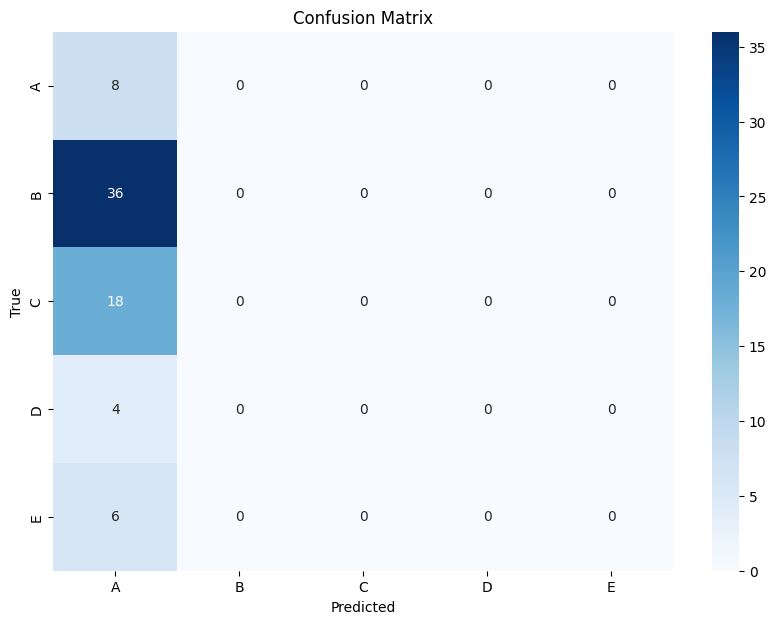

In [32]:
import seaborn as sns

import matplotlib.pyplot as plt

label = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues', 
    xticklabels=[f'{label[i]}' for i in range(cm.shape[1])], 
    yticklabels=[f'{label[i]}' for i in range(cm.shape[0])]
    )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# /home/masa1357/Dockerdata/gitfile/15-Encoders/src/log/15layers/hidden_states/all_hidden_states_20241004162013.pt
# ↑のファイルを読み込む
# -> 15層のhidden_statesを読み込む
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# # ファイルパス
# path = Path("/home/masa1357/Dockerdata/gitfile/15-Encoders/src/log/15layers/hidden_states/all_hidden_states_20241004162013.pt")
# # ファイル読み込み
# hidden_states = torch.load(path)


In [38]:
import torch
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import os
import random

# 隠れ状態のファイルが保存されているディレクトリ
hidden_state_dir = "/home/masa1357/Dockerdata/gitfile/15-Encoders/src/log/15layers/hidden_states/"

# 指定したディレクトリからランダムにファイルを取得する関数
def get_random_files(dir_path, num_files=3):
    # ディレクトリ内のすべてのファイルを取得
    all_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.pt')]
    
    # ランダムにファイルを選択
    selected_files = random.sample(all_files, num_files)
    return selected_files

def load_hidden_states(file_path):
    # file_pathに従って隠れ状態を読み込む
    hidden_states = torch.load(file_path)
    
    # hidden_statesがtupleなら各要素にdetach()とnumpy()を適用
    if isinstance(hidden_states, tuple):
        hidden_states = [state.detach().cpu().numpy() for state in hidden_states]
    else:
        # tupleでない場合は直接処理
        hidden_states = hidden_states.detach().cpu().numpy()

    return hidden_states

# ランダムに3つのファイルを取得
file_paths = get_random_files(hidden_state_dir, num_files=3)

# 各ファイルからhidden_statesを読み込み、PCAで次元削減を行う
hidden_states_list = [load_hidden_states(file_path) for file_path in file_paths]

# PCAで次元を3次元に削減する
def apply_pca(hidden_states, n_components=3):
    pca = PCA(n_components=n_components)
    reduced_states = [pca.fit_transform(state.reshape(-1, state.shape[-1])) for state in hidden_states]
    return reduced_states

# PCAを適用して次元を削減
reduced_hidden_states_list = [apply_pca(hidden_states) for hidden_states in hidden_states_list]

# 色のリストを準備（ファイルごとに色を変える）
colors = ['red', 'blue', 'green']

# 時系列ごとにプロットを作成する
fig = go.Figure()

# 各ファイル（データセット）ごとに異なる色でプロットを追加
for file_index, reduced_hidden_states in enumerate(reduced_hidden_states_list):
    for layer_index, reduced_state in enumerate(reduced_hidden_states):
        x, y, z = reduced_state[:, 0], reduced_state[:, 1], reduced_state[:, 2]
        
        # 各レイヤーに対する散布図
        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(
                size=1,
                opacity=0.8,
                color=colors[file_index],  # ファイルごとの色分け
            ),
            name=f'File {file_index+1}, Layer {layer_index}'
        ))

# スライダーを作成
steps = []
for i in range(len(reduced_hidden_states_list[0])):  # 最初のファイルのレイヤー数に基づく
    step = dict(
        method='update',
        args=[{'visible': [j == i for j in range(len(reduced_hidden_states_list[0]))]},
              {'title': f"Layer {i}"}],
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Layer: "},
    pad={"t": 50},
    steps=steps
)]

# レイアウトを設定
fig.update_layout(
    sliders=sliders,
    title="Hidden States - Random File-wise Visualization",
    scene=dict(
        xaxis_title="PCA1",
        yaxis_title="PCA2",
        zaxis_title="PCA3",
    ),
    width=1000,
    height=1000
)

# プロットを表示
fig.show()
